## 1.Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import gc
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import scipy.stats  as stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/kaggle-ranks/final_rank.png
/kaggle/input/kaggle-ranks/Final_rank_acc.png
/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv
/kaggle/input/m5-forecasting-uncertainty/calendar.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv
/kaggle/input/modelling-40/models.sav
/kaggle/input/modelling-40/custom.css
/kaggle/input/modelling-40/__notebook__.ipynb
/kaggle/input/modelling-40/__results__.html
/kaggle/input/modelling-40/__output__.json
/kaggle/input/features-new/data.h5
/kaggle/input/features-new/custom.css
/kaggle/input/features-ne

## 2.Reading the Data

* Reading the saved data from the New_featurization notebook.

In [2]:
data = pd.read_hdf('/kaggle/input/features-new/data.h5', 'data')

## 3. Taking the test_data

In [3]:
test_data = data[(data['date']>'2016-05-22')]
del data

In [4]:
import pickle
filename = 'test_data.csv'
pickle.dump(test_data, open(filename, 'wb'))

In [5]:
features_w1 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wm_yr_wk', 
            'event_name_1', 'event_type_1','event_name_2', 'event_type_2','snap_CA', 'snap_TX',
            'snap_WI','sell_price', 'price_max', 'price_min', 'price_std', 'price_mean',
            'price_nunique', 'item_nunique', 'encoded_id', 'lag_d_7', 'lag_d_8','lag_d_9',
            'r_std_d7', 'r_std_d14','r_std_d30', 'r_mean_d7', 'r_mean_d14', 
            'r_mean_d30', 'tm_d', 'tm_w','tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']

features_w2 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wm_yr_wk', 
            'event_name_1', 'event_type_1','event_name_2', 'event_type_2','snap_CA', 'snap_TX',
            'snap_WI','sell_price', 'price_max', 'price_min', 'price_std', 'price_mean',
            'price_nunique', 'item_nunique', 'encoded_id','lag_d_14', 'lag_d_15', 'lag_d_16',
            'r_std_d7', 'r_std_d14','r_std_d30', 'r_mean_d7', 'r_mean_d14', 
            'r_mean_d30', 'tm_d', 'tm_w','tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']

features_w3 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wm_yr_wk', 
            'event_name_1', 'event_type_1','event_name_2', 'event_type_2','snap_CA', 'snap_TX',
            'snap_WI','sell_price', 'price_max', 'price_min', 'price_std', 'price_mean',
            'price_nunique', 'item_nunique', 'encoded_id','lag_d_21', 'lag_d_22','lag_d_23',
            'r_std_d7', 'r_std_d14','r_std_d30', 'r_mean_d7', 'r_mean_d14',
            'r_mean_d30', 'tm_d', 'tm_w','tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']

features_w4 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wm_yr_wk', 
            'event_name_1', 'event_type_1','event_name_2', 'event_type_2','snap_CA', 'snap_TX',
            'snap_WI','sell_price', 'price_max', 'price_min', 'price_std', 'price_mean',
            'price_nunique', 'item_nunique', 'encoded_id', 'lag_d_28','lag_d_29', 'lag_d_30',
            'r_std_d7', 'r_std_d14','r_std_d30', 'r_mean_d7', 'r_mean_d14', 
            'r_mean_d30', 'tm_d', 'tm_w','tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']
features_list = [features_w1,features_w2,features_w3,features_w4]

In [6]:
data_list=[]
def data_list_fn():
    for j in range(1,5):
        for i in range(10):
            data_list.append(f'data_s{i}_w{j}')
data_list_fn()
#print(data_list)
model_list = []
def model_list_fn():
    for j in range(1,5):
        for i in range(10):
            model_list.append(f'model_s{i}_w{j}')
model_list_fn()
#print(model_list)


test_data_parts={}
week_start = [23,30,6,13]
week_end = [29,5,12,19]
            

def ramu_data(data_list,data,data_parts):
    m = 0
    for j,k in zip(week_start,week_end):
        for i in range(10):
            data_parts[data_list[m]]=data[(data['store_id']==i) & ((data['tm_d']>=j)&(data['tm_d']<=k))]
            m+=1


            
def ramu_data2(data_list,data,data_parts):
    m = 10
    for i in range(10):
        data_parts[data_list[m]]=data[(data['store_id']==i) & ((data['tm_d']>=30) | (data['tm_d']<=5))]
        m+=1


ramu_data(data_list,test_data,test_data_parts)
ramu_data2(data_list,test_data,test_data_parts)

del test_data

In [7]:
test_data_parts
filename = 'test_data_parts'
pickle.dump(test_data_parts, open(filename, 'wb'))

## 4. Importing saved models.

In [8]:
import pickle
location = open("../input/modelling-40/models.sav","rb")
model_data_parts= pickle.load(location)

In [9]:
def prediction(features_list,model_data_parts,model_list,data_list,test_data_parts):
    m=0
    for i in features_list:
        for k in range(10):
            model= model_data_parts.get(model_list[m])
            y_pred = model.predict(test_data_parts.get(data_list[m])[i], num_iteration=model.best_iteration)
            test_data_parts.get(data_list[m])[['unit_sales']] = y_pred
            m+=1
prediction(features_list,model_data_parts,model_list,data_list,test_data_parts)

In [10]:
concat_list = []
for i in range(40):
    concat_list.append(test_data_parts.get(data_list[i]))

final_test_data =  pd.concat(concat_list,axis=0)
final_test_data = final_test_data[['id','unit_sales','date']].pivot(index='id', columns='date')
day_test_columns = [f'F{row}' for row in range(1,29)]
final_test_data.columns = day_test_columns
final_test_data.reset_index(inplace=True)
final_test_data

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.860252,0.642676,0.538725,0.613534,0.735416,0.802001,0.661766,0.657223,0.633590,...,0.800169,0.961353,0.923060,0.834732,0.778139,0.720542,0.799706,0.901315,1.053665,0.882263
1,FOODS_1_001_CA_2_evaluation,0.799323,0.917508,0.999827,0.894951,1.081540,1.606342,1.259709,0.870456,0.961161,...,1.037692,1.669976,1.471518,0.868509,0.800426,0.790383,0.747872,0.933171,1.115649,0.891026
2,FOODS_1_001_CA_3_evaluation,0.969509,0.688482,0.649790,1.003365,0.783880,1.500915,1.403524,0.574354,0.507106,...,0.795452,0.988752,1.030854,1.112460,1.243856,1.168748,1.061741,1.004998,1.404042,1.136865
3,FOODS_1_001_CA_4_evaluation,0.284669,0.267054,0.326526,0.320034,0.312176,0.320695,0.304057,0.283229,0.274686,...,0.462894,0.410758,0.354975,0.273156,0.263025,0.290180,0.296786,0.289666,0.362007,0.355576
4,FOODS_1_001_TX_1_evaluation,0.625342,1.222735,0.595707,0.617745,0.672762,0.630552,0.675996,0.575113,0.700211,...,0.469305,0.516843,0.635786,0.483907,0.567073,0.510721,0.523475,0.542034,0.544647,0.573820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.371829,0.317567,0.369362,0.302105,0.332291,0.315450,0.411963,0.220498,0.230046,...,0.206224,0.226650,0.280007,0.155157,0.139964,0.140449,0.142320,0.146473,0.167966,0.177253
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.155988,0.091385,0.097908,0.093753,0.147295,0.243546,0.254428,0.126490,0.113671,...,0.205376,0.275853,0.318579,0.125636,0.127949,0.129002,0.132027,0.157755,0.222563,0.235576
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.062964,0.065254,0.067520,0.074407,0.085769,0.120530,0.105839,0.084166,0.088505,...,0.123723,0.158688,0.132334,0.069557,0.090250,0.089522,0.094551,0.110328,0.129359,0.109477
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.091194,0.082074,0.069442,0.047514,0.049120,0.048298,0.050003,0.066172,0.078077,...,0.023581,0.024654,0.036215,0.067478,0.070142,0.069308,0.073320,0.073796,0.077278,0.060283


## 5. Reading the sales data to get the validation data.

In [11]:
sales = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')

In [12]:
id2 = ['id']
val_columns = [f'd_{row}' for row in range(1914,1942)]
id2.extend(val_columns)
final_validation_data = sales[id2]
id1 = ['id']
day_val_columns = [f'F{row}' for row in range(1,29)]
id1.extend(day_val_columns)
final_validation_data.columns = id1
final_validation_data

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,2,2,0,0,0,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,0,0,1,1,0,2,1,1,0,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,1,3,0,1,2,1,0,2,1,...,1,1,1,4,6,0,1,1,1,0


In [13]:
final_submission_accuracy_data = pd.concat([final_validation_data,final_test_data],axis=0)
final_submission_accuracy_data

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,5.000000,0.000000,0.000000,...,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,1.000000
1,HOBBIES_1_002_CA_1_evaluation,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,HOBBIES_1_003_CA_1_evaluation,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000
3,HOBBIES_1_004_CA_1_evaluation,0.000000,0.000000,1.000000,2.000000,4.000000,1.000000,6.000000,4.000000,0.000000,...,1.000000,1.000000,0.000000,4.000000,0.000000,1.000000,3.000000,0.000000,2.000000,6.000000
4,HOBBIES_1_005_CA_1_evaluation,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.371829,0.317567,0.369362,0.302105,0.332291,0.315450,0.411963,0.220498,0.230046,...,0.206224,0.226650,0.280007,0.155157,0.139964,0.140449,0.142320,0.146473,0.167966,0.177253
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.155988,0.091385,0.097908,0.093753,0.147295,0.243546,0.254428,0.126490,0.113671,...,0.205376,0.275853,0.318579,0.125636,0.127949,0.129002,0.132027,0.157755,0.222563,0.235576
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.062964,0.065254,0.067520,0.074407,0.085769,0.120530,0.105839,0.084166,0.088505,...,0.123723,0.158688,0.132334,0.069557,0.090250,0.089522,0.094551,0.110328,0.129359,0.109477
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.091194,0.082074,0.069442,0.047514,0.049120,0.048298,0.050003,0.066172,0.078077,...,0.023581,0.024654,0.036215,0.067478,0.070142,0.069308,0.073320,0.073796,0.077278,0.060283


In [14]:
import pickle
filename1 = 'final_test.csv'
pickle.dump(final_test_data, open(filename1, 'wb'))
filename2 = 'final_validation.csv'
pickle.dump(final_validation_data, open(filename1, 'wb'))
filename3 = 'final_submission_acc.csv'
pickle.dump(final_submission_accuracy_data, open(filename3, 'wb'))

## 6. Point Forecast to Uncertainty

In [15]:
sales = pd.read_csv("../input/m5-forecasting-uncertainty/sales_train_evaluation.csv")
sub_val = final_validation_data.merge(sales[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]], on = "id")
sub_val["_all_"] = "Total"
sub_eval = final_test_data.merge(sales[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]], on = "id")
sub_eval["_all_"] = "Total"

qs = np.array([0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995])  # 9 quantile values

qs2 = np.log(qs/(1-qs))*0.07
ratios = stats.norm.cdf(qs2)

ratios/=ratios[4]  # division based on the middle(center) value.
ratios = pd.Series(ratios, index=qs)
ratios.round(3)   # rounding off to 3 decimal values

def quantile_coefficients(q):
    return ratios.loc[q].values

def individual_aggregation(df, level):
    df = df.groupby(level)[cols].sum()
    q = np.repeat(qs, len(df))
    df = pd.concat([df]*9, axis=0, sort=False)
    df.reset_index(inplace=True)
    df[cols]*= quantile_coefficients(q)[:, None]
    if level != 'id':
        df['id'] = [f"{l}_X_{q:.3f}_evaluation" for l,q in zip(df[level].values, q)]
    else:
        df['id'] = [f"{l.replace('_evaluation','')}_{q:.3f}_evaluation" for l,q in zip(df[level].values,q)]
    df = df[['id']+list(cols)]
    return df

def grouped_aggregation(df,level1,level2):
    df = df.groupby([level1,level2])[cols].sum()
    q = np.repeat(qs,len(df))
    df = pd.concat([df]*9,axis=0,sort = False)
    df.reset_index(inplace=True)
    df[cols] *= quantile_coefficients(q)[:, None]
    df['id']= [f'{l1}_{l2}_{q:.3f}_evaluation' for l1,l2,q in 
              zip(df[level1].values,df[level2].values,q)]
    df = df[['id']+list(cols)]
    return df

individual = ['id','item_id','dept_id','cat_id','store_id','state_id','_all_']
grouped = [('state_id','item_id'),('state_id','dept_id'),('store_id','dept_id'),
           ('state_id','cat_id'),('store_id','cat_id')]
cols = [f'F{i}' for i in range(1,29)]


df_v = []
for level in individual :
    df_v.append(individual_aggregation(sub_val, level))
for level1,level2 in grouped:
    df_v.append(grouped_aggregation(sub_val, level1, level2))
df_v = pd.concat(df_v, axis=0, sort=False)
df_v.reset_index(drop=True, inplace=True)

df_t = []
for level in individual :
    df_t.append(individual_aggregation(sub_eval, level))
for level1,level2 in grouped:
    df_t.append(grouped_aggregation(sub_eval, level1, level2))
df_t = pd.concat(df_t, axis=0, sort=False)
df_t.reset_index(drop=True, inplace=True)

df = pd.concat([df_v,df_t] , axis=0, sort=False)
df.reset_index(drop=True, inplace=True)
df.loc[df.index < len(df.index)//2, "id"] = df.loc[df.index < len(df.index)//2, "id"].str.replace("_evaluation","_validation")

df.to_csv("submission_un_0.07.csv",float_format='%.3g',index = False)

from zipfile import ZipFile
zipObj = ZipFile('submission_un_0.07.zip', 'w')
# Add multiple files to the zip
zipObj.write('submission_un_0.07.csv')
zipObj.close()
from IPython.display import FileLink
FileLink(r'./submission_un_0.07.zip')

/kaggle/working/submission_un_0.07.zip

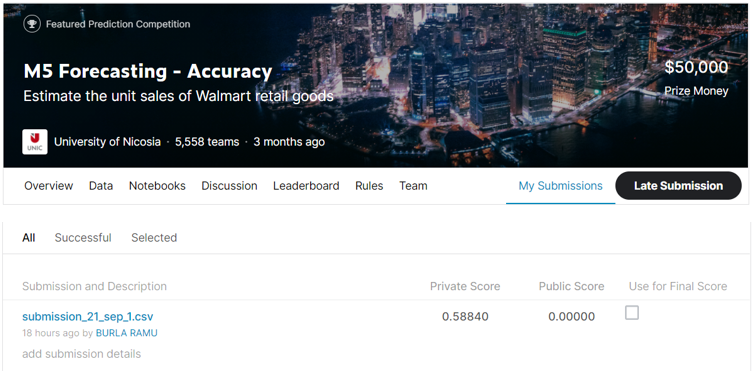

In [16]:
from IPython.display import Image

Image(filename='../input/kaggle-ranks/Final_rank_acc.png')                                                                                               

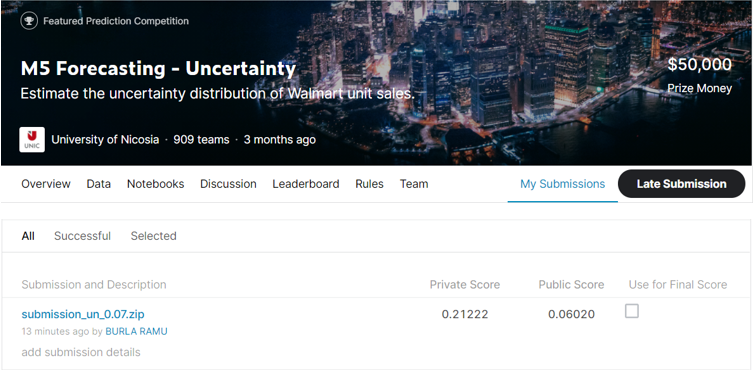

In [17]:
Image(filename='../input/kaggle-ranks/final_rank.png') 

# 1. FORECASTING ACCURACY COMPETITION  

###### GOT A RANK OF 72/5558 WITHIN TOP 1.5% OF THE COMPETITION.

# 2. FORECASTING UNCERTAINTY COMPETITION

###### GOT A RANK OF 253/909.

## Summary


### 3. Taking the test_data

* Taken the test data and divided it into 40 dataframes based on week and store. (Just like train and validation)



### 4. Importing saved models.

* Imported the saved models from the trained notebook.
* Predicted all the 40 models output individually and concat all the test data of features id and unit_sales.
* Replaced the column names based on the sample_submission data.



### 6. Point Forecast to Uncertainty

* Created the qantile list and their ratios.
* for all the 9 values of quantiles, concated 9 same dataframes and multiplied them with different quantile ratios.
* created new id names based on the sample_submission file.
* aggregated the data group wise.
* concatenated validation and evaluation data for the final submission.

